In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load datasets
movies_metadata_path = 'data/movie_lens/movies_metadata.csv'
ratings_path = 'data/movie_lens/ratings.csv'
user_survey_path = 'data/user_survey.csv'
credits_path = 'data/movie_lens/credits.csv'
keywords_path = 'data/movie_lens/keywords.csv'
links_path = 'data/movie_lens/links.csv'

movies_metadata = pd.read_csv(movies_metadata_path, low_memory=False)
ratings = pd.read_csv(ratings_path)
user_survey = pd.read_csv(user_survey_path)
credits = pd.read_csv(credits_path)
keywords = pd.read_csv(keywords_path)
links = pd.read_csv(links_path)

# 1. Data Cleaning

In [3]:
"""Data Cleaning"""

# Cleaning movies_metadata dataset
movies_metadata.drop_duplicates(inplace=True)
# Handle missing values - Drop columns where a high percentage of data is missing
missing_threshold = 0.5
movies_metadata = movies_metadata[movies_metadata.columns[movies_metadata.isnull().mean() < missing_threshold]]
# Drop rows with missing values in critical columns like 'title'
movies_metadata.dropna(subset=['title'], inplace=True)
# Normalize numerical columns (e.g., budget, runtime)
movies_metadata['budget'] = pd.to_numeric(movies_metadata['budget'], errors='coerce').fillna(0)
movies_metadata['runtime'] = pd.to_numeric(movies_metadata['runtime'], errors='coerce').fillna(movies_metadata['runtime'].median())
movies_metadata['id'] = pd.to_numeric(movies_metadata['id'], errors='coerce')

# Cleaning ratings dataset
ratings.drop_duplicates(inplace=True)
ratings.dropna(inplace=True)
ratings['movieId'] = pd.to_numeric(ratings['movieId'], errors='coerce')

# Cleaning user survey dataset
user_survey.drop_duplicates(inplace=True)
user_survey.fillna('Unknown', inplace=True)

# Rename columns for easier access
user_survey.columns = user_survey.columns.str.strip()
user_survey.rename(columns={
    'What are your favorite movie genres? (Select up to three)': 'Favorite_Genres'
}, inplace=True)

# Cleaning credits dataset
credits.drop_duplicates(inplace=True)
credits.dropna(inplace=True)
credits['id'] = pd.to_numeric(credits['id'], errors='coerce')

# Cleaning keywords dataset
keywords.drop_duplicates(inplace=True)
keywords.dropna(inplace=True)
keywords['id'] = pd.to_numeric(keywords['id'], errors='coerce')

# Cleaning links dataset
links.drop_duplicates(inplace=True)
links.dropna(inplace=True)
links['movieId'] = pd.to_numeric(links['movieId'], errors='coerce')

# 2. Exploratory Data Analysis (EDA)

### Movie Genre Analysis

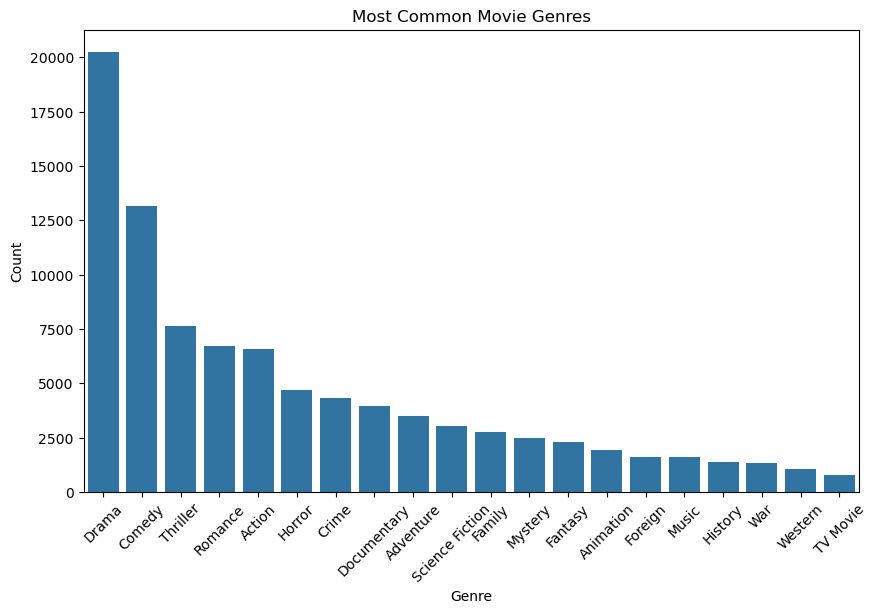

In [4]:
# Genre Analysis - Extract and visualize genres
movies_metadata['genres'] = movies_metadata['genres'].fillna('[]').apply(lambda x: [i['name'] for i in eval(x)] if isinstance(x, str) else [])
all_genres = [genre for genres_list in movies_metadata['genres'] for genre in genres_list]
genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.title('Most Common Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Movie ratings analysis

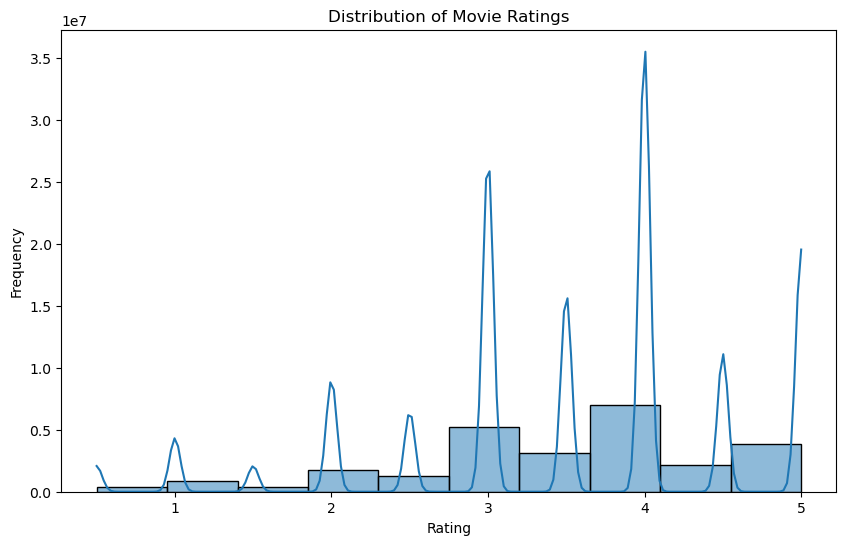

In [5]:
# Ratings Analysis - Distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

### Popular Movies | Top-rated movies

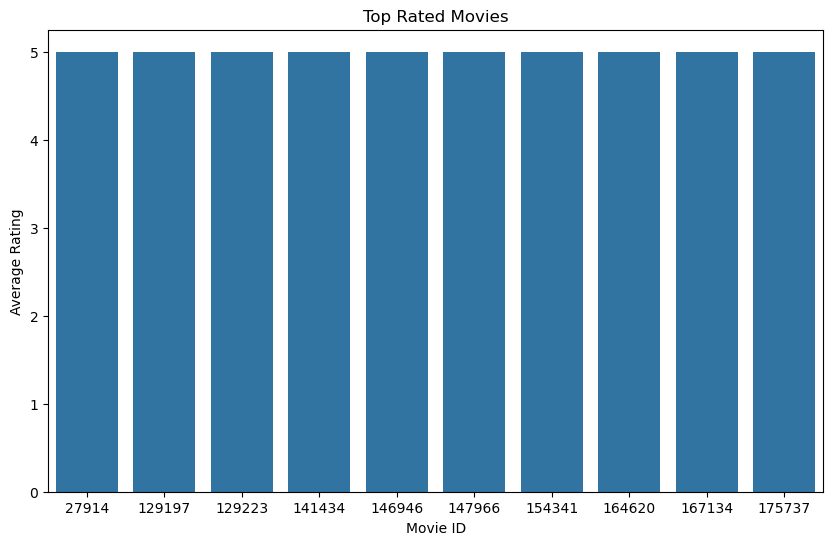

In [6]:
avg_ratings = ratings.groupby('movieId')['rating'].mean()
popular_movies = avg_ratings.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=popular_movies.index, y=popular_movies.values)
plt.title('Top Rated Movies')
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.show()

### User Survey Analysis

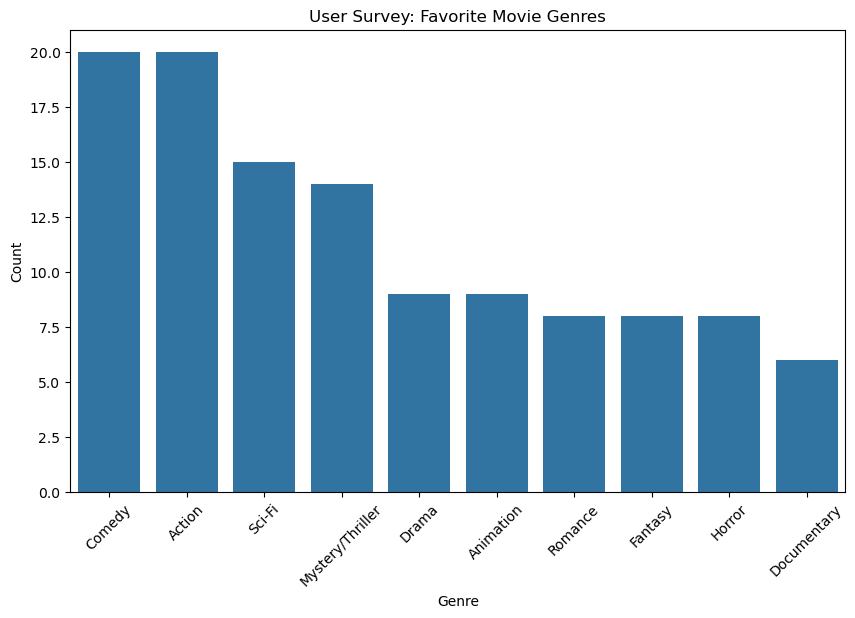

In [7]:
user_survey['Favorite_Genres'] = user_survey['Favorite_Genres'].str.split(';')
all_survey_genres = [genre for genres_list in user_survey['Favorite_Genres'] for genre in genres_list]
survey_genre_counts = pd.Series(all_survey_genres).value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=survey_genre_counts.index, y=survey_genre_counts.values)
plt.title('User Survey: Favorite Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Credits Analysis - Cast and Crew

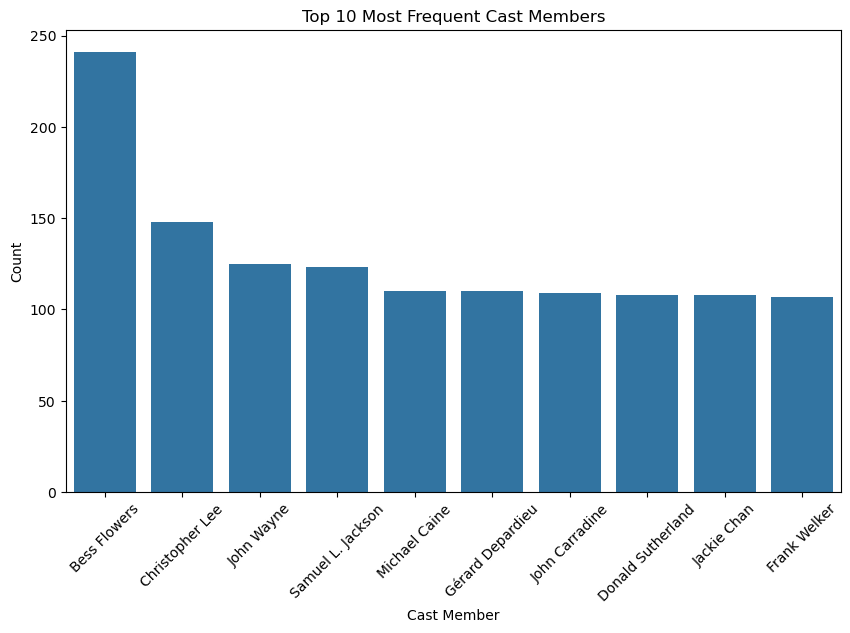

In [8]:
credits['cast'] = credits['cast'].fillna('[]').apply(lambda x: [i['name'] for i in eval(x)] if isinstance(x, str) else [])
all_cast = [cast_member for cast_list in credits['cast'] for cast_member in cast_list]
cast_counts = pd.Series(all_cast).value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=cast_counts.index, y=cast_counts.values)
plt.title('Top 10 Most Frequent Cast Members')
plt.xlabel('Cast Member')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Keywords Analysis

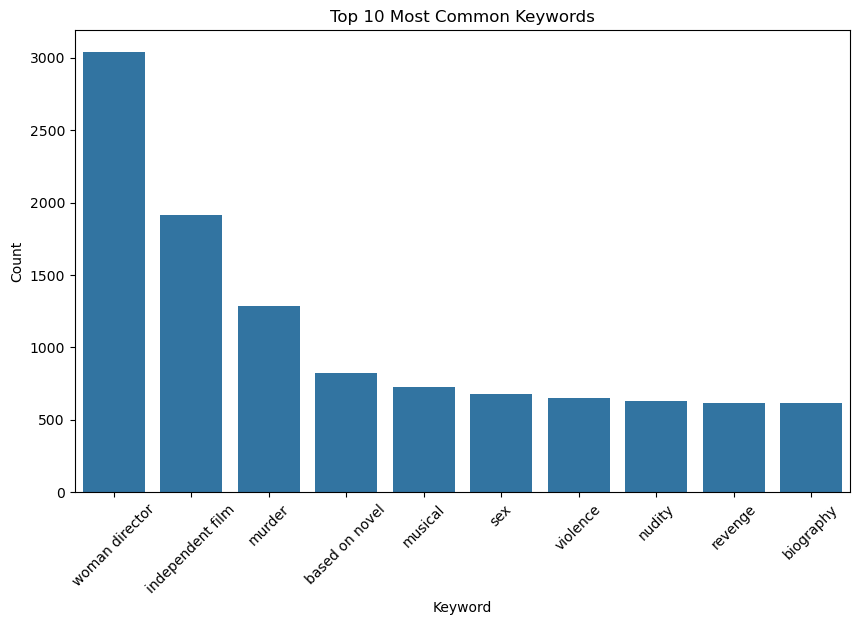

In [9]:
keywords['keywords'] = keywords['keywords'].fillna('[]').apply(lambda x: [i['name'] for i in eval(x)] if isinstance(x, str) else [])
all_keywords = [keyword for keyword_list in keywords['keywords'] for keyword in keyword_list]
keyword_counts = pd.Series(all_keywords).value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_counts.index, y=keyword_counts.values)
plt.title('Top 10 Most Common Keywords')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 3. Preparing Final Dataset for Model Training

In [10]:
# Merge movies_metadata, ratings, credits, keywords, and links datasets
final_dataset = pd.merge(ratings, movies_metadata, left_on='movieId', right_on='id', how='inner')
final_dataset = pd.merge(final_dataset, credits, left_on='movieId', right_on='id', how='left')
final_dataset = pd.merge(final_dataset, keywords, left_on='movieId', right_on='id', how='left')
final_dataset = pd.merge(final_dataset, links, left_on='movieId', right_on='movieId', how='left')

In [11]:
# Encode genres using MultiLabelBinarizer for better similarity computation
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(movies_metadata['genres']), columns=mlb.classes_, index=movies_metadata.index)
final_dataset = pd.concat([final_dataset, genres_encoded], axis=1)

In [12]:
# Extract relevant features for recommendation (e.g., genres, cast, keywords)
final_dataset['cast'] = final_dataset['cast'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
final_dataset['keywords'] = final_dataset['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

# Combine text features for content-based filtering
final_dataset['combined_features'] = final_dataset['genres'].apply(lambda x: ' '.join(x)) + ' ' + final_dataset['cast'] + ' ' + final_dataset['keywords']

In [13]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_dataset, test_size=0.2, random_state=42)

MemoryError: Unable to allocate 1.62 GiB for an array with shape (19, 11439460) and data type object

In [ ]:
# Final normalized dataset ready for model training
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [ ]:
# Save cleaned and prepared data for future use
train.to_csv('data/train_dataset.csv', index=False)
test.to_csv('data/test_dataset.csv', index=False)
print("Data preprocessing and EDA completed successfully.")